测试优化：
$$
min f(x)=x_1^4-2x_2x_1^2+x_2^2+x_1^2-2x_1+5\\
s.t. -(x_1+0.25)^2+0.75x_2\leq 0
$$



In [217]:
import numpy as np
from scipy import sparse
def f(x):
    return np.array(x[0]**4-2*x[1]*x[0]**2+x[1]**2+x[0]**2-2*x[0]+5)

def df(x):
    return np.array([4 * x[0] ** 3 - 4 * x[1] * x[0] + 2 * x[0] - 2, -2 * x[0] ** 2 + 2 * x[1]])       

def c(x):
    return np.array([-(x[0] + 0.25) ** 2 + 0.75 * x[1]])

def dc(x):
    return np.array([[-2 * x[0] - 0.5, 0.75]])

def dd_lagrange(x, v):
    return np.array([[12 * x[0] ** 2 - 4 * x[1] + 2, -4 * x[0]], 
                     [-4 * x[0], 2]]) + v * np.array([[-2, 0], [0, 0]])

In [218]:

import osqp
print("f(x0)=",f([3.0,3.0]))
x0=np.array([10.0,10.0])
lambda0=np.array([1.0])
solver=osqp.OSQP()
P_mat=sparse.csc_matrix(dd_lagrange(x0,lambda0))
q_vec=df(x0)
A=sparse.csc_matrix(dc(x0))
l=np.array([-np.inf])
u=-c(x0)

solver.setup(P=P_mat,q=q_vec,A=A,l=l,u=u)
results=solver.solve()
delta_x=results.x
print("constrain value:",c(x0+delta_x))
print("new_x",x0+delta_x)
print("new_lambda:",results.y)
print("f(x)=",f(x0+results.x))
print(results.info.obj_val)
print("obj_value:",0.5*P_mat.dot(results.x).dot(results.x)+q_vec.dot(results.x))


f(x0)= 44.0
-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 1
          nnz(P) + nnz(A) = 5
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.9517e+03   3.52e-14   2.95e+03   1.00e-01   3.02e-05s
  25  -8.1004e+03   3.52e-14   2.49e+00   1.00e-01   4.64e-05s

status:               solved
number of

In [219]:
f_log=[]
x_log=[]
lambda_log=[]
x_k=x0
lambda_k=lambda0
for optim_iter in range(10):
    P_mat=sparse.csc_matrix(dd_lagrange(x_k,lambda_k))
    q_vec=df(x_k)
    A=sparse.csc_matrix(dc(x_k))
    l=np.array([-np.inf])
    u=-c(x_k)
    solver=osqp.OSQP()
    solver.setup(P=P_mat,q=q_vec,A=A,l=l,u=u)
    # solver.warm_start(x=np.zeros(2), y=lambda_k)
    results=solver.solve()
    
    delta_x=results.x
    lambda_k1=results.y
    print("constrain value:",c(x_k+delta_x))
    print("new_x",x_k+delta_x)
    print("new_lambda:",lambda_k1)
    f_log.append(f(x_k+delta_x))
    x_log.append(x_k+delta_x)
    lambda_log.append(lambda_k1)
    print("f(x)=",f_log[-1])
    x_k=x_k+delta_x
    lambda_k=lambda_k1
    
print("f_log:",f_log)
print()
print("x_log:",x_log)
print()
print("lambda_log:",lambda_log)

-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2, constraints m = 1
          nnz(P) + nnz(A) = 5
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -3.9517e+03   3.52e-14   2.95e+03   1.00e-01   5.49e-05s
  25  -8.1004e+03   3.52e-14   2.49e+00   1.00e-01   6.27e-05s

status:               solved
number of iterations:

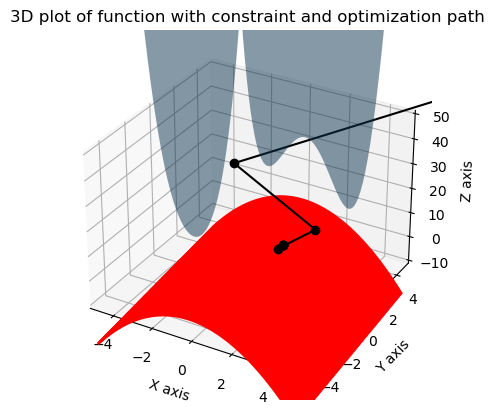

In [220]:
# draw f figure by matplotlib
# at the same time, draw constrain c and x_log on this figure
import matplotlib.pyplot as plt

# 创建一个网格点
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)
z = f([x, y])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# 画出函数f的曲面
ax.plot_surface(x, y, z, alpha=0.5, rstride=100, cstride=100)

# 画出约束曲线
for xi, yi in zip(x, y):
    zi = -(xi + 0.25)**2 + 0.75 * yi
    ax.plot(xi, yi, zi, 'r', lw=2)

# 标记出优化点列
x_vals = [val[0] for val in x_log]
y_vals = [val[1] for val in x_log]
z_vals = [f(val) for val in x_log]
ax.plot(x_vals, y_vals, z_vals, color="k", marker="o", label="Optimization Path")

# 设置标签和标题
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D plot of function with constraint and optimization path')

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-10,100)

plt.show()